# Detecting the Milky Way on 2024/05/31!!!

Load the observations from that night.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# for logging
from time import time
import logging

# to save output data and parameters
from datetime import datetime
import yaml
import os

# If running outside of the rtlobs github repo,
# add path
import sys
sys.path.append('/home/stellarmate/rtlobs')
from rtlobs import collect as col
from rtlobs import post_process as post
from rtlobs import utils as ut

In [2]:
############################################################
# 21cm rest-frame frequency
nu21cm = 1420405751.768 # [Hz]

# Exposure parameters
param = {}
param['nSample'] = 8192 # samples per call to the SDR, to avoid loading too much in RAM
param['nBin'] = 512   #1024   #2048   # number of freq bins for  power spectrum 
param['gain'] = 49.6 # [dB] of RtlSdr gain
param['sampleRate'] = 2.32e6   #3.2e6  # [Hz] sample rate of the SDR, which determines bandwidth of spectrum
param['centerFrequency'] = nu21cm # [GHz] center frequency
param['integrationTime'] = 5*60  #5 * 60  # [sec] integration time

# Frequency shifting parameters
#throwFrequency = nu21cm + 1.e6 # [Hz] alternate frequency. The freq diff has to be less than achieved bandwidth
frequencyShift = 2.5e6   # freq offset between fiducial and shifted frequencies [Hz]
param['throwFrequency'] = nu21cm + frequencyShift # [Hz] alternate frequency. The freq diff has to be less than achieved bandwidth
# Too bad, I would like a shift of 3.e6 Hz for my 21cm line...
param['alternatingFrequency'] = 1.   # [Hz] frequency at which we switch between fiducial and shifted freqs


# create header for output file to log these parameters
headerOutputFile =  "Exposure settings:\n"
headerOutputFile += "nSample = "+str(param['nSample'])+" # samples per call to the SDR\n"
headerOutputFile += "nBin = "+str(param['nBin'])+" # bin resolution power spectrum \n"
headerOutputFile += "gain = "+str(param['gain'])+" # [dB] of RtlSdr gain\n"
headerOutputFile += "sample rate = "+str(param['sampleRate'])+" # [Hz] controls bandwidth\n"
headerOutputFile += "centerFrequency = "+str(param['centerFrequency'])+" # [Hz] center frequency\n"
headerOutputFile += "integrationTime = "+str(param['integrationTime'])+" # [sec] integration time\n"
headerOutputFile += "alternateFrequency = "+str(param['throwFrequency'])+" # [Hz] alternate frequency\n"
headerOutputFile += "alternatingFrequency = "+str(param['alternatingFrequency'])+" # [Hz] alternating frequency\n"


#################################################################
# Create output and figure folders

# get today's date as yyyymmdd
param['dateCapture'] = "20240531"

# Output path
pathOut = "./output/"+param['dateCapture']
if not os.path.exists(pathOut):
   os.makedirs(pathOut)

# Figures path
pathFig = "./figures/"+param['dateCapture']
if not os.path.exists(pathFig):
   os.makedirs(pathFig)

In [46]:
#################################################################
# read all 'reduced' exposures into array

import os
import re
from datetime import datetime

def list_files_reduced_chronological(directory):
    # list all files in directory
    files = os.listdir(directory)

    # filter to keep only those ending with 'reduced.txt'
    matching_files = [file for file in files if file.endswith('reduced.txt')]

    # define a regex to extract the timestamp
    time_pattern = re.compile(r'(\d{8}_\d{2}h\d{2}m\d{2}s)')

    # function to extract datetime object from filename
    def extract_time(file):
        match = time_pattern.search(file)
        if match:
            time_str = match.group(1)
            # convert to datetime object
            return datetime.strptime(time_str, "%Y%m%d_%Hh%Mm%Ss")
        else:
            # fallback if no match
            return datetime.min

    # sort files by extracted time
    matching_files.sort(key=extract_time)

    return matching_files

filesReduced = list_files_reduced_chronological(pathOut)


         #headerOutputFileFinal += 'foff, poff, fon, pon, foff, poff, pBase, pDiffBase, pDiffBaseSmart\n'
dataReduced = np.zeros((len(filesReduced), param['nBin'], 9))
for iFile in range(len(filesReduced)):
   file = filesReduced[iFile]
   dataReduced[iFile, :, :] = np.loadtxt(pathOut + '/' + file)

# parse the low and high exposures
pHigh = np.zeros_like(dataReduced[:,:,0])
pLow = np.zeros_like(pHigh)
for iFile in range(len(filesReduced)):
    if dataReduced[iFile,0,0] < dataReduced[iFile,0,4]:
        fLow = dataReduced[iFile,:,0]
        pLow[iFile,:] = dataReduced[iFile,:,1]
        fHigh = dataReduced[iFile,:,4]
        pHigh[iFile,:] = dataReduced[iFile,:,5]
    else:
        fHigh = dataReduced[iFile,:,0]
        pHigh[iFile,:] = dataReduced[iFile,:,1]
        fLow = dataReduced[iFile,:,4]
        pLow[iFile,:] = dataReduced[iFile,:,5]       

FOn = dataReduced[:,:,2]
fOn = dataReduced[0,:,2]
pOn = dataReduced[:,:,3]
pBase = dataReduced[:,:,6]
pSub = pOn - pBase
pCalib = pOn / pBase - 1
pSub = pOn - pBase
pOnMean = np.mean(pOn, axis=0)
pOnMin = np.min(pOn, axis=0)
pBaseMean = np.mean(pBase, axis=0)
pCalibMean = np.mean(pCalib, axis=0)
pSubMean = np.mean(pSub, axis=0)
#
pCalibRenorm = np.zeros_like(pCalib)
for iFile in range(len(filesReduced)):
   pCalibRenorm[iFile,:] = pCalib[iFile,:] / pCalib[iFile, param['nBin']//2]

In [47]:
print(filesReduced)

['exposure_high_300sec_20240531_03h29m10s_reduced.txt', 'exposure_low_300sec_20240531_03h39m46s_reduced.txt', 'exposure_high_300sec_20240531_04h10m29s_reduced.txt', 'exposure_low_300sec_20240531_04h21m05s_reduced.txt', 'exposure_high_300sec_20240531_05h09m37s_reduced.txt', 'exposure_low_300sec_20240531_05h20m15s_reduced.txt', 'exposure_high_300sec_20240531_05h30m52s_reduced.txt', 'exposure_low_300sec_20240531_05h41m29s_reduced.txt', 'exposure_high_300sec_20240531_05h52m07s_reduced.txt', 'exposure_low_300sec_20240531_06h02m45s_reduced.txt', 'exposure_high_300sec_20240531_06h13m30s_reduced.txt', 'exposure_low_300sec_20240531_06h24m14s_reduced.txt', 'exposure_high_300sec_20240531_06h34m53s_reduced.txt', 'exposure_low_300sec_20240531_06h45m37s_reduced.txt', 'exposure_high_300sec_20240531_06h56m28s_reduced.txt', 'exposure_low_300sec_20240531_07h07m15s_reduced.txt']


In [48]:
def basePlot():
    fig=plt.figure(0)
    ax=fig.add_subplot(111)
    #
    ax.axvline(0., c='k', label=r'$\nu^0_\text{21cm}$')
    #
    # f = (fOn[I] - nu21cm) / 1.e6 # [MHz]
    # p = pOn[iFile,I] / pOnMeanNoMW[I] - 1.
    # ax.plot(f, p, '--', label=r'truncated')
    #
    # Add alternate x axis showing velocities
    ax2 = ax.twiny()
    c = 299792458.e-3  # speed of light [km/s]
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels( np.round(ax.get_xticks()*1.e6/nu21cm * c, 1))
    ax2.set_xlabel(r'$v_\text{LOS}$ [km/s]')
    #
    ax.legend(loc=2)
    ax.set_xlabel(r'$\nu - \nu^0_\text{21cm}$ [MHz]')
    ax.set_ylabel(r'Uncalibrated intensity [au]')

    return fig, ax, ax2

# Raw exposures at the fiducial frequency throughout the night

The ON exposures show large RFI spikes.
They also show a coherent up and down variation at all frequencies, over time.
Presumably due to thermal variations in the antenna and receiver electronics through the night.

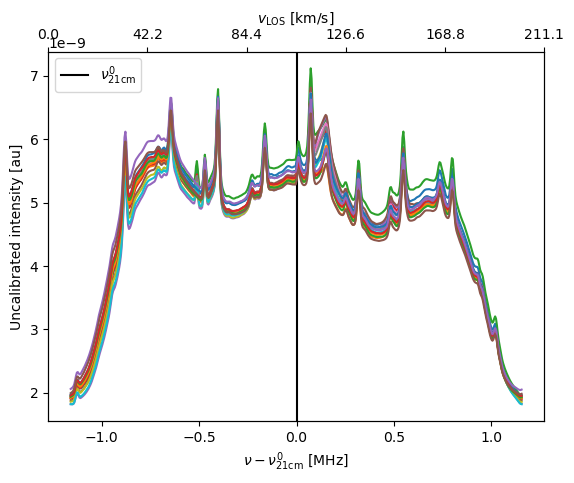

In [49]:
fig, ax, ax2 = basePlot()
#
for iFile in range(len(filesReduced)):
   ax.plot((fOn-nu21cm) / 1.e6, pOn[iFile,:])

plt.show()

# New attempt at calibration

In this section, I copy and paste the better analysis cells from a later observation session. The variable names may not make complete sense here. But what I am doing is simply taking each spectrum, dividing by a reference spectrum away from the Milky Way (cold exposure). In practice, this reference exposure is just the last one in the drift scan sequence.
Then I do a 3rd order poly fit for the baseline, which I subtract. The fit is done on the frequencies away from the visible 21cm bump.

Pick the last exposure as reference.

In [50]:
iRefExp = -1

In [51]:
import diy21cm as d21
import os
from datetime import datetime
import json_io as json
import numpy as np, matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# to generate gifs
import imageio

In [52]:
POn = pOn.copy()

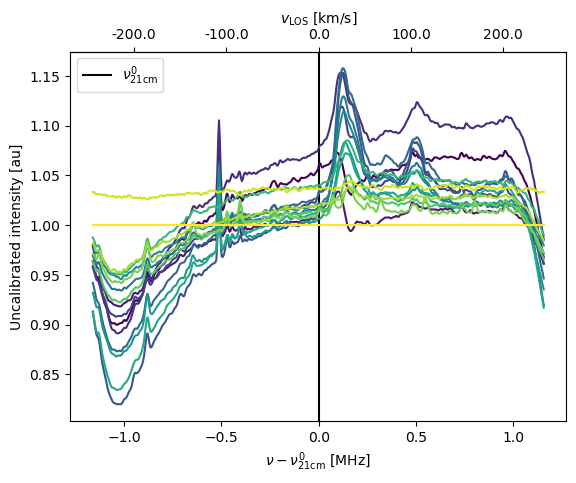

In [53]:

POnOverRef = pOn / pOn[iRefExp, :]

fig, ax, ax2 = d21.plot(FOn, POnOverRef)

Try simply rescaling each spectrum by an amplitude. Doesn't help at the moment.

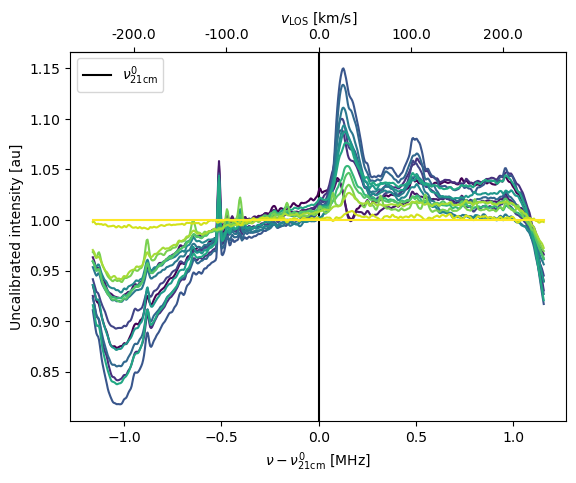

In [54]:
ref = POn[iRefExp, :]  # reference row
dot_products = np.sum(POn * ref, axis=1)         # shape (N,)
row_norms_squared = np.sum(POn**2, axis=1)       # shape (N,)
scaling_factors = dot_products / row_norms_squared  # shape (N,)

POnOverRefRescaled = (POn / ref) * scaling_factors[:, None]

fig, ax, ax2 = d21.plot(FOn, POnOverRefRescaled)

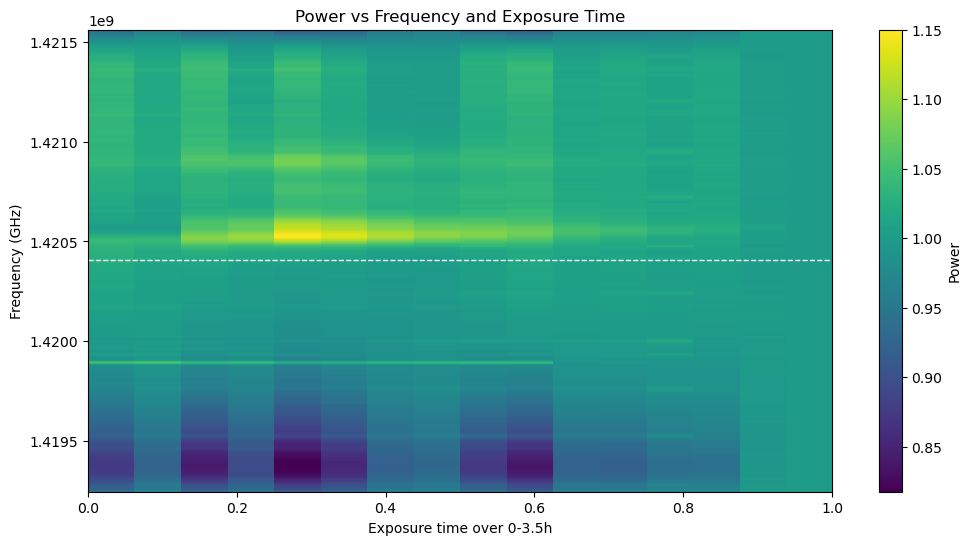

In [82]:
plt.figure(figsize=(12, 6))

# Plot with freq on Y and exposure time on X
plt.imshow(POnOverRefRescaled.T, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest',
           extent=[0., 1., FOn[0][0], FOn[0][-1]])

plt.axhline(d21.nu21cm, color='w', linestyle='--', linewidth=1)

plt.xlabel('Exposure time over 0-3.5h')
plt.ylabel('Frequency (GHz)')
plt.title('Power vs Frequency and Exposure Time')
plt.colorbar(label='Power')

plt.show()

Mask the frequencies where a baseline subtraction will be tricky

In [83]:
IFreqTrim = np.where(
    (FOn[0, :] > d21.nu21cm - 0.4e6) &(FOn[0, :] < d21.nu21cm + 0.9e6)
)[0]

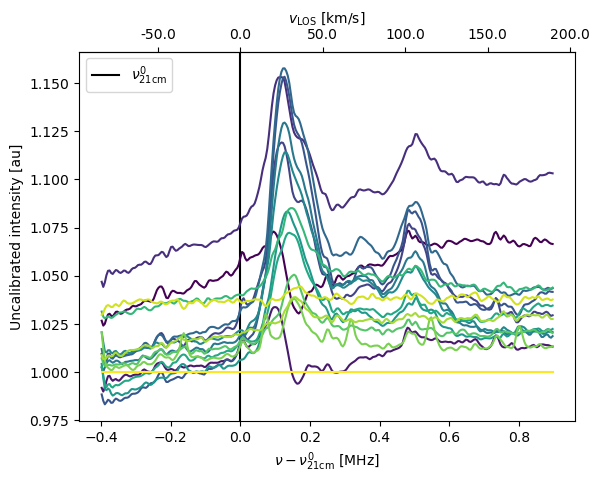

In [84]:
POnOverHotFmasked = POnOverRef[:,IFreqTrim]
FOnFmasked = FOn[:,IFreqTrim]

fig, ax, ax2 = d21.plot(FOnFmasked, POnOverHotFmasked)

In [85]:
def fit_polynomial(x, y, degree):
    """
    Fit a polynomial of given degree to data (x, y).
    
    Parameters:
        x (array-like): 1D array of independent variable values.
        y (array-like): 1D array of dependent variable values.
        degree (int): Degree of the polynomial to fit.
    
    Returns:
        poly (np.poly1d): A polynomial object you can evaluate like a function.
    """
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    return poly

Test the fit on one of the exposures showing a prominent 21cm bump

In [86]:
iTest = 5

Adjust the range of frequencies used for the fit, to avoid fiitting away the 21cm bump.

In [88]:
IFreqFit = np.where(
    (FOnFmasked[iTest, :] < d21.nu21cm - 0.1e6) |
    (FOnFmasked[iTest, :] > d21.nu21cm + 0.7e6)
)[0]

In [89]:
x = FOnFmasked[iTest,IFreqFit]
y = POnOverHotFmasked[iTest,IFreqFit]

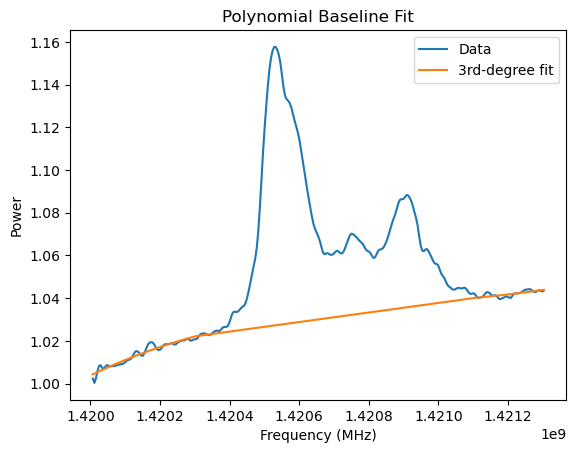

In [91]:
# Fit a degree-3 polynomial
poly = fit_polynomial(x, y, degree=3)

# Evaluate the polynomial
y_fit = poly(x)

# Plot

plt.plot(FOnFmasked[iTest,:], POnOverHotFmasked[iTest,:], label='Data', markersize=3)
plt.plot(x, y_fit, '-', label='3rd-degree fit')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power')
plt.title('Polynomial Baseline Fit')
plt.legend()
plt.show()

In [92]:
POnOverHotBasesub = np.zeros_like(POnOverHotFmasked)

for i in range(len(FOnFmasked[:,0])):
    x = FOnFmasked[i,IFreqFit]
    y = POnOverHotFmasked[i,IFreqFit]

    # Fit a degree-5 polynomial
    poly = fit_polynomial(x, y, degree=3)
    
    # Evaluate the polynomial
    y_fit = poly(FOnFmasked[i,:])

    POnOverHotBasesub[i,:] = POnOverHotFmasked[i,:] - y_fit


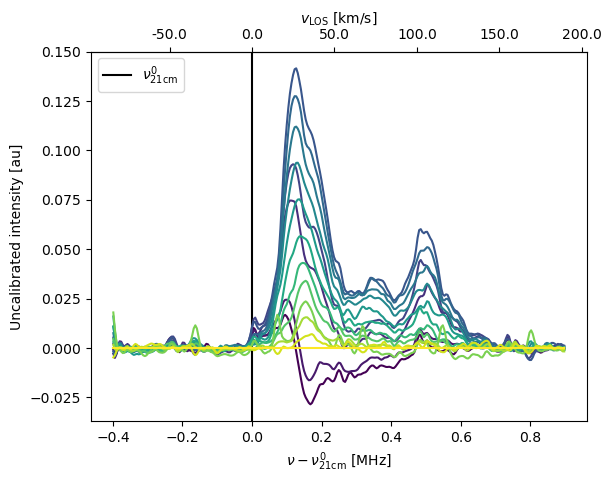

In [93]:
fig, ax, ax2 = d21.plot(FOnFmasked, POnOverHotBasesub)

Waterfall plot

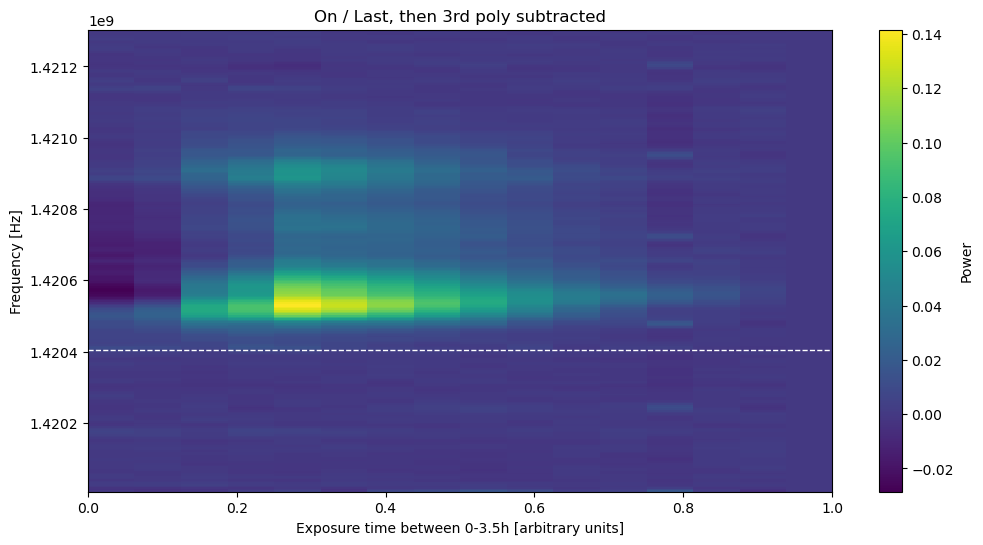

In [94]:
plt.figure(figsize=(12, 6))

# Plot with freq on Y and exposure time on X
plt.imshow(POnOverHotBasesub.T, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest',
           extent=[0., 1., FOnFmasked[0][0], FOnFmasked[0][-1]])
plt.axhline(d21.nu21cm, color='w', linestyle='--', linewidth=1)

plt.xlabel('Exposure time between 0-3.5h [arbitrary units]')
plt.ylabel('Frequency [Hz]')
plt.title('On / Last, then 3rd poly subtracted')
plt.colorbar(label='Power')

plt.show()